In [20]:
# magic command to display matplotlib plots inline within the ipython notebook
%matplotlib inline

# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
import json
from shapely.geometry import Point
from geopy.distance import great_circle
import requests
from scipy import ndimage
import seaborn as sns
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = 10, 8

### Part 1: Overview of Shapely

### Part 2: Overview of Geopandas Using Open Berkeley Data

The data for this tutorial were pulled from the City of Berkeley Open Data Portal, from their Data Catalog:
https://data.cityofberkeley.info/browse?limitTo=datasets&utf8

The filenames pulled from the portal follow a format of 'geo_export' plys a long generated string.  The spatial dataaets had several options for formats to export.  For this tutorial Shapefile format was selected.

The datasets pulled for this were:
* Census blocks 2010
* 311 cases (filtered for Grafitti and Vandalism)
* Parcel boundaries

In addition, a shapefile of BART stations was pulled from a CALTRANS site: http://www.dot.ca.gov/hq/tsip/gis/datalibrary/Metadata/BART_13.html


### GeoSeries: The geometry building block
Like a Pandas Series, a GeoSeries is the building block for the more broadly useful and powerful GeoDataFrame that we’ll focus on in this tutorial. Here we’ll take a bit of time to examine a GeoSeries.

A GeoSeries is made up of an index and a GeoPandas geometry data type. This data type is a shapely.geometry object, and therefore inherits their attributes and methods such as area, bounds, distance, etc.

GeoPandas has six classes of geometric objects, corresponding to the three basic single-entity geometric types and their associated homogeneous collections of multiples entities:

Single entity (core, basic types):
Point
Line (formally known as a LineString)
Polygon
Homogeneous entity collections:
Multi-Point
Multi-Line (MultiLineString)
Multi-Polygon
A GeoSeries is then a list of geometry objects and their associated index values.

#### Create a GeoSeries from a list of shapely Point objects
Then enhance it with a crs and plot it.

In [32]:
gs = gpd.GeoSeries([Point(-120, 45), Point(-121.2, 46), Point(-122.9, 47.5)])
gs

0        POINT (-120 45)
1      POINT (-121.2 46)
2    POINT (-122.9 47.5)
dtype: object

In [33]:
type(gs), len(gs)

(geopandas.geoseries.GeoSeries, 3)

A GeoSeries (and a GeoDataframe) can store a CRS implicitly associated with the geometry column. This is useful as essential spatial metadata and for transformation (reprojection) to another CRS.

In [34]:
gs.crs = {'init': 'epsg:4326'}

The plot method accepts standard matplotlib.pyplot style options, and can be tweaked like any other matplotlib figure.

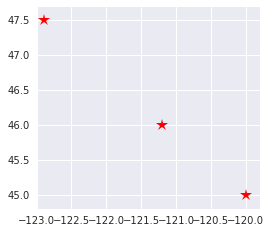

In [35]:
gs.plot(marker='*', color='red', markersize=12, figsize=(4, 4))
plt.xlim([-123, -119.8])
plt.ylim([44.8, 47.7]);

## Creating a GeoDataFrame using GeoPandas

## Loading Berkeley Census Block Polygon Shapefile

OK, let's jump in and begin loading some Berkeley data.  We will start with 2010 census blocks.

In [2]:
census = requests.get('http://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/nycd/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=geojson')

In [3]:
with open('new_york_census.geojson', 'w') as f:
    json.dump(census.json(), f)

In [4]:
blocks = gpd.read_file('new_york_census.geojson')

blocks.head()

,BoroCD,OBJECTID,Shape__Area,Shape__Length,geometry
0,311,1,0.001020,0.164766,"POLYGON ((-73.972995771055 40.608822378954, -7..."
1,412,2,0.002646,0.208863,"POLYGON ((-73.8016840458066 40.6663306069896, ..."
2,481,3,0.000471,0.164230,"POLYGON ((-73.83591704463601 40.7434391617455,..."
3,314,4,0.000813,0.150767,"POLYGON ((-73.956301780335 40.6550565286466, -..."
4,313,5,0.000871,0.215657,"POLYGON ((-73.9837229604689 40.5958293124404, ..."


In [5]:
blocks.shape

(71, 5)

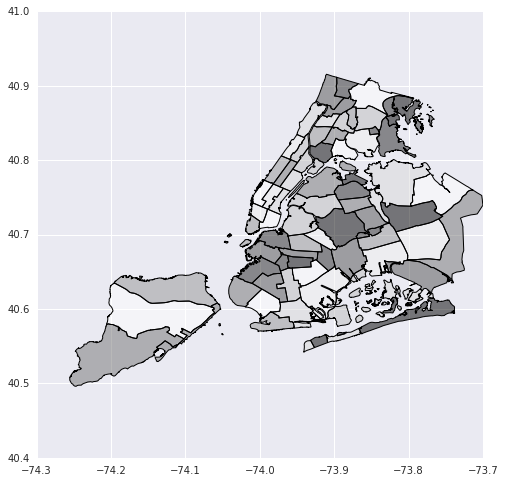

In [24]:
blocks.plot();

### Dealing With Coordinate Reference Systems (CRS)

With geospatial data, you have to be aware of the coordinate system the data is stored in.  Latitude - Longitude is in spherical coordinates, from -180 to 180 Longitude, and -180 to 180 Latitude.  For most purposes that require working with more localized data at an urban scale, spatial datasets are generally projected on to a coordinate system that is appropriate for measurements on a flat surface.

Geopandas let's you easily find out the crs of a dataset, and change it to another (project the dataset) as needed.

In [7]:
blocks.crs

{'init': 'epsg:4326'}

### Loading 311 Cases as Point Data

Let's load 311 data , droppin rows that have missing data (a good fraction of the data seem to be missing latitude and longitude)

In [9]:
complaints = pd.read_csv('nyc_complaints_data_inclass.csv').dropna()
complaints= complaints[complaints['Complaint Type'] == 'Illegal Parking']

In [10]:
complaints.shape

(671, 15)

We loaded a csv into a standard pandas DataFrame. But it contains Latitude, Longitude columns, so with a couple of additional steps we can turn this into a GeoDataFrame, and set its crs.

In [11]:
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(complaints.Longitude, complaints.Latitude)]
geocomplaints = GeoDataFrame(complaints, crs=crs, geometry=geometry)
geocomplaints.head()

,Unnamed: 0,Created Date,Closed Date,Agency Name,Complaint Type,Status,Street Name,Location Type,Borough,Latitude,Longitude,created_timestamp,created_hour,created_month,created_day,geometry
77,1311409,08/31/2015 10:48:31 AM,09/01/2015 03:02:23 AM,New York City Police Department,Illegal Parking,Closed,EAST 96 STREET,Street/Sidewalk,MANHATTAN,40.784866,-73.948579,1.441007e+09,10,8,0,POINT (-73.9485786619811 40.7848662982225)
90,1268639,08/27/2015 11:04:50 AM,08/27/2015 01:19:06 PM,New York City Police Department,Illegal Parking,Closed,BEACH 101 STREET,Street/Sidewalk,QUEENS,40.585097,-73.822684,1.440663e+09,11,8,3,POINT (-73.82268411479096 40.58509734988783)
100,926316,08/12/2015 07:08:58 AM,08/12/2015 12:20:17 PM,New York City Police Department,Illegal Parking,Closed,NAUGHTON AVENUE,Street/Sidewalk,STATEN ISLAND,40.581669,-74.089800,1.439353e+09,7,8,2,POINT (-74.08979996689702 40.58166926208053)
143,332289,08/22/2015 12:42:48 AM,08/22/2015 04:19:24 AM,New York City Police Department,Illegal Parking,Closed,PAYSON AVENUE,Street/Sidewalk,MANHATTAN,40.867243,-73.927997,1.440237e+09,12,8,5,POINT (-73.92799687001796 40.86724341738395)
154,1217954,08/10/2015 11:12:28 AM,08/10/2015 03:06:06 PM,New York City Police Department,Illegal Parking,Closed,JOHN STREET,Street/Sidewalk,BROOKLYN,40.704376,-73.985750,1.439194e+09,11,8,0,POINT (-73.98574997265524 40.70437612818832)


In [12]:
print(type(geocomplaints))
print(geocomplaints.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
{'init': 'epsg:4326'}


OK, now it looks good, so let's see what it looks like mapped.

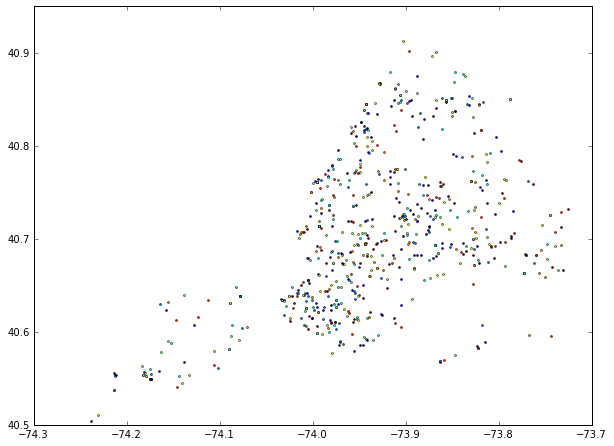

In [13]:
geocomplaints.plot();

### Mapping With Layers

A bunch of points mapped is not very informative, since it lacks context.  Let's add the points to the block base to add visual context.

NOTE: the maps are going to be pretty slow.  Especially when we get to more detailed maps.  Note the circle in the upper right of the Jupyter notebook that goes solid while Python is running. Just wait for it to go white again, and you'll see maps appear.

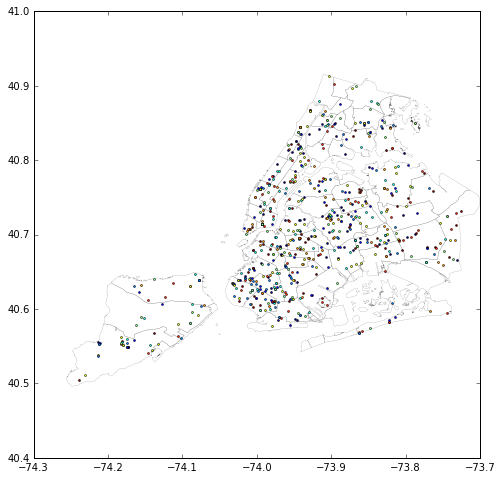

In [14]:
base = blocks.plot(color='white', linewidth=.1)
geocomplaints.plot(ax=base);

### Spatial Joins
A spatial join uses binary predicates such as intersects and crosses to combine two GeoDataFrames based on the spatial relationship between their geometries.

A common use case might be a spatial join between a point layer and a polygon layer where you want to retain the point geometries and grab the attributes of the intersecting polygons.

## Types of spatial joins
We currently support the following methods of spatial joins. We refer to the left_df and right_df which are the correspond to the two dataframes passed in as args.

### Left outer join
In a LEFT OUTER JOIN (how='left'), we keep all rows from the left and duplicate them if necessary to represent multiple hits between the two dataframes. We retain attributes of the right if they intersect and lose right rows that don't intersect. A left outer join implies that we are interested in retaining the geometries of the left.

In [27]:
join_left_df = gpd.sjoin(geocomplaints, blocks, how="left")
join_left_df.head()

,Unnamed: 0,Created Date,Closed Date,Agency Name,Complaint Type,Status,Street Name,Location Type,Borough,Latitude,...,created_timestamp,created_hour,created_month,created_day,geometry,index_right,BoroCD,OBJECTID,Shape__Area,Shape__Length
77,1311409,08/31/2015 10:48:31 AM,09/01/2015 03:02:23 AM,New York City Police Department,Illegal Parking,Closed,EAST 96 STREET,Street/Sidewalk,MANHATTAN,40.784866,...,1.441007e+09,10,8,0,POINT (-73.9485786619811 40.7848662982225),65,108,66,0.000547,0.163978
90,1268639,08/27/2015 11:04:50 AM,08/27/2015 01:19:06 PM,New York City Police Department,Illegal Parking,Closed,BEACH 101 STREET,Street/Sidewalk,QUEENS,40.585097,...,1.440663e+09,11,8,3,POINT (-73.82268411479096 40.58509734988783),26,414,27,0.001934,0.685198
100,926316,08/12/2015 07:08:58 AM,08/12/2015 12:20:17 PM,New York City Police Department,Illegal Parking,Closed,NAUGHTON AVENUE,Street/Sidewalk,STATEN ISLAND,40.581669,...,1.439353e+09,7,8,2,POINT (-74.08979996689702 40.58166926208053),63,502,64,0.005862,0.463983
143,332289,08/22/2015 12:42:48 AM,08/22/2015 04:19:24 AM,New York City Police Department,Illegal Parking,Closed,PAYSON AVENUE,Street/Sidewalk,MANHATTAN,40.867243,...,1.440237e+09,12,8,5,POINT (-73.92799687001796 40.86724341738395),38,112,39,0.000774,0.173046
154,1217954,08/10/2015 11:12:28 AM,08/10/2015 03:06:06 PM,New York City Police Department,Illegal Parking,Closed,JOHN STREET,Street/Sidewalk,BROOKLYN,40.704376,...,1.439194e+09,11,8,0,POINT (-73.98574997265524 40.70437612818832),70,302,71,0.000785,0.236501


### Right outer join
In a RIGHT OUTER JOIN (how='right'), we keep all rows from the right and duplicate them if necessary to represent multiple hits between the two dataframes. We retain attributes of the left if they intersect and lose left rows that don't intersect. A right outer join implies that we are interested in retaining the geometries of the right.



In [28]:
join_right_df = gpd.sjoin(geocomplaints, blocks, how="right")
join_right_df.head()

,Unnamed: 0,Created Date,Closed Date,Agency Name,Complaint Type,Status,Street Name,Location Type,Borough,Latitude,...,created_timestamp,created_hour,created_month,created_day,index_left,BoroCD,OBJECTID,Shape__Area,Shape__Length,geometry
index_right,,,,,,,,,,,,,,,,,,,,,
65.0,1311409.0,08/31/2015 10:48:31 AM,09/01/2015 03:02:23 AM,New York City Police Department,Illegal Parking,Closed,EAST 96 STREET,Street/Sidewalk,MANHATTAN,40.784866,...,1.441007e+09,10.0,8.0,0.0,77.0,108,66,0.000547,0.163978,"(POLYGON ((-73.9418017586504 40.7690551962931,..."
65.0,1203189.0,08/07/2015 01:25:53 PM,08/07/2015 10:14:43 PM,New York City Police Department,Illegal Parking,Closed,EAST 76 STREET,Street/Sidewalk,MANHATTAN,40.770860,...,1.438900e+09,1.0,8.0,4.0,3640.0,108,66,0.000547,0.163978,"(POLYGON ((-73.9418017586504 40.7690551962931,..."
65.0,1261799.0,08/18/2015 10:08:58 AM,08/18/2015 11:48:13 AM,New York City Police Department,Illegal Parking,Closed,EAST 72 STREET,Street/Sidewalk,MANHATTAN,40.770783,...,1.439882e+09,10.0,8.0,1.0,6657.0,108,66,0.000547,0.163978,"(POLYGON ((-73.9418017586504 40.7690551962931,..."
65.0,1302722.0,08/30/2015 08:15:14 PM,08/30/2015 10:42:44 PM,New York City Police Department,Illegal Parking,Closed,EAST 64 STREET,Street/Sidewalk,MANHATTAN,40.763292,...,1.440912e+09,8.0,8.0,6.0,9226.0,108,66,0.000547,0.163978,"(POLYGON ((-73.9418017586504 40.7690551962931,..."
65.0,1204978.0,08/02/2015 11:17:09 AM,08/02/2015 11:37:43 AM,New York City Police Department,Illegal Parking,Closed,EAST 81 STREET,Street/Sidewalk,MANHATTAN,40.774320,...,1.438503e+09,11.0,8.0,6.0,9425.0,108,66,0.000547,0.163978,"(POLYGON ((-73.9418017586504 40.7690551962931,..."


### Inner join
In an INNER JOIN (how='inner'), we keep rows from the right and left only where their binary predicate is True. We duplicate them if necessary to represent multiple hits between the two dataframes. We retain attributes of the right and left only if they intersect and lose all rows that do not. An inner join implies that we are interested in retaining the geometries of the left.



In [29]:
join_inner_df = gpd.sjoin(geocomplaints, blocks, how="inner")
join_inner_df.head()

,Unnamed: 0,Created Date,Closed Date,Agency Name,Complaint Type,Status,Street Name,Location Type,Borough,Latitude,...,created_timestamp,created_hour,created_month,created_day,geometry,index_right,BoroCD,OBJECTID,Shape__Area,Shape__Length
77,1311409,08/31/2015 10:48:31 AM,09/01/2015 03:02:23 AM,New York City Police Department,Illegal Parking,Closed,EAST 96 STREET,Street/Sidewalk,MANHATTAN,40.784866,...,1.441007e+09,10,8,0,POINT (-73.9485786619811 40.7848662982225),65,108,66,0.000547,0.163978
3640,1203189,08/07/2015 01:25:53 PM,08/07/2015 10:14:43 PM,New York City Police Department,Illegal Parking,Closed,EAST 76 STREET,Street/Sidewalk,MANHATTAN,40.770860,...,1.438900e+09,1,8,4,POINT (-73.95520352789281 40.77085992746439),65,108,66,0.000547,0.163978
6657,1261799,08/18/2015 10:08:58 AM,08/18/2015 11:48:13 AM,New York City Police Department,Illegal Parking,Closed,EAST 72 STREET,Street/Sidewalk,MANHATTAN,40.770783,...,1.439882e+09,10,8,1,POINT (-73.96303789925585 40.7707831095786),65,108,66,0.000547,0.163978
9226,1302722,08/30/2015 08:15:14 PM,08/30/2015 10:42:44 PM,New York City Police Department,Illegal Parking,Closed,EAST 64 STREET,Street/Sidewalk,MANHATTAN,40.763292,...,1.440912e+09,8,8,6,POINT (-73.96103496347446 40.76329205112742),65,108,66,0.000547,0.163978
9425,1204978,08/02/2015 11:17:09 AM,08/02/2015 11:37:43 AM,New York City Police Department,Illegal Parking,Closed,EAST 81 STREET,Street/Sidewalk,MANHATTAN,40.774320,...,1.438503e+09,11,8,6,POINT (-73.95327681566508 40.77432027810254),65,108,66,0.000547,0.163978


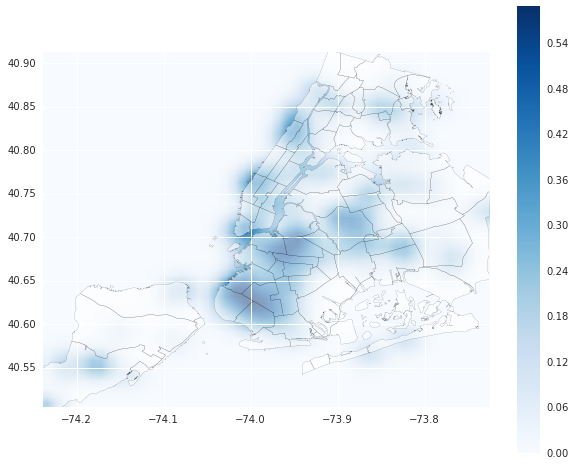

In [30]:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap="Blues"):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    #return logheatmap
    blocks.plot(color='white', linewidth=.1)

    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

heatmap(join_inner_df, bins=50, smoothing=1.3)